# Search for ICESat-2 tracks coincident with MOSAIC floe
This notebook presents a workflow for searching for and downloading ICESat-2 granules that are coincident with the Polarstern drift trajectory during the MOSAIC project. 

Currently it uses _ad-hoc_ python scripts as wrapper for the CMR API, in particular the `&circle` parameter for spatial searches.  In the (very near) future, this search capability will be added to `icepyx`.  Although the workflow has been developed to search for granules intersecting the Polarstern drift, it could be applied to buoys, flightlines, etc.  All that is needed is a file of points defining a trajectory. 

In [25]:
import sys
sys.path.append("/home/apbarret/src/SunlightUnderSeaIce/sunderseaice")  # Allow import of modules for sunderseaice
sys.path.append("/home/apbarret/src/nsidc_projections/nsidc_projections")

import os
import datetime as dt
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LinearRing

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import icepyx as ipx

import h5py
import xarray as xr

import download.nsidc_download as cmr
from grid import SSMI_PolarStereoNorth25km 

DATAPATH = '/home/apbarret/src/SunlightUnderSeaIce/data'

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    map_proj = SSMI_PolarStereoNorth25km.to_cartopy()
map_extent = [-2349878.8355433852, 2349878.8355433857, -2349878.8355433852, 2349878.8355433857]

## Read Polarstern trajectory
I'm using a trajectory provided by Julienne Stroeve, which she obtained from the MOSAIC project.  I want to load this data into a `geopandas.GeoSeries`.  I use `pandas.read_csv` to read the file first.  However, as you can see below, the file is not a standard text file.  There also look to be some strange characters in the files, which suggests that the character encoding will not be recognized by `pandas`.

In [2]:
!head /home/apbarret/src/SunlightUnderSeaIce/data/pstrack.dat

date time	SYS.STR.PosLat	SYS.STR.PosLon
	spot	spot
	�	�
2019/09/20 00:00:00	 	 
2019/09/20 01:00:00	 	 
2019/09/20 02:00:00	 	 
2019/09/20 03:00:00	 	 
2019/09/20 04:00:00	 	 
2019/09/20 05:00:00	 	 
2019/09/20 06:00:00	 	 


In Unix flavoured OS, the `file` command can be used to find the encoding.  It can be seen that the encoding is _ISO-8859_, which includes characters found in European languages.  This encoding can be specified in using the `encoding` keyword to `pandas.read_csv`. 

In [3]:
!file /home/apbarret/src/SunlightUnderSeaIce/data/pstrack.dat

/home/apbarret/src/SunlightUnderSeaIce/data/pstrack.dat: ISO-8859 text


The function below reads the Polarstern track into a `pandas.DataFrame` and does some cleaning, such as changing the column names to Latitude and Longitude, and drops rows with no data.  The second function creates a `geopandas.GeoSeries`.  I assume coordinates are on the WGS84 horizontal datum (EPSG:4326), which I suspect is correct because the data come from a shipboard GPS.  All GPS use WGS84.

In [4]:
def read_pstrack(filepath):
    '''Reads Polarstern passage, cleans data and creates a pandas dataframe indexed by datetime'''
    df = pd.read_csv(filepath, encoding="ISO-8859-1", sep="\t", header=0, 
                 skiprows=[1,2], parse_dates=['date time'], index_col='date time')
    
    df.rename({"SYS.STR.PosLat": "Latitude", "SYS.STR.PosLon": "Longitude"}, axis="columns", inplace=True)
    df.index.name = "datetime"
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.dropna()
    
    return df


def pandas_to_geopandas(df, crs="EPSG:4326"):
    """Returns a geopandas dataseries"""
    geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    return gpd.GeoSeries(geometry, index=df.index, crs=crs)


In [5]:
# Read the file
filepath = os.path.join(DATAPATH, 'pstrack.dat')
track_hour_df = read_pstrack(filepath)
track_hour_df.head()

,Latitude,Longitude
datetime,,
2019-09-20 15:00:00,69.679548,18.996655
2019-09-20 16:00:00,69.679548,18.996648
2019-09-20 17:00:00,69.679545,18.996645
2019-09-20 18:00:00,69.679548,18.996640
2019-09-20 19:00:00,69.683804,19.025313


In [6]:
track_hour_df['2019-10-15':'2020-05-16']

,Latitude,Longitude
datetime,,
2019-10-15 00:00:00,84.756102,134.387568
2019-10-15 01:00:00,84.756850,134.372910
2019-10-15 02:00:00,84.757965,134.361346
2019-10-15 03:00:00,84.759235,134.354813
2019-10-15 04:00:00,84.760435,134.354664
...,...,...
2020-05-16 19:00:00,83.387839,9.107153
2020-05-16 20:00:00,83.387355,9.107437
2020-05-16 21:00:00,83.387090,9.096386


In [7]:
# Convert to a GeoSeries
gdf = pandas_to_geopandas(track_hour_df)
gdf.head()

datetime
2019-09-20 15:00:00    POINT (18.99666 69.67955)
2019-09-20 16:00:00    POINT (18.99665 69.67955)
2019-09-20 17:00:00    POINT (18.99665 69.67954)
2019-09-20 18:00:00    POINT (18.99664 69.67955)
2019-09-20 19:00:00    POINT (19.02531 69.68380)
dtype: geometry

The points are plotted below.  Note, the points need to be converted to the NSIDC Polar Stereographic projection to plot correctly. 

In [8]:
gdf = gdf.to_crs(SSMI_PolarStereoNorth25km.epsg) 

<GeoAxesSubplot:>

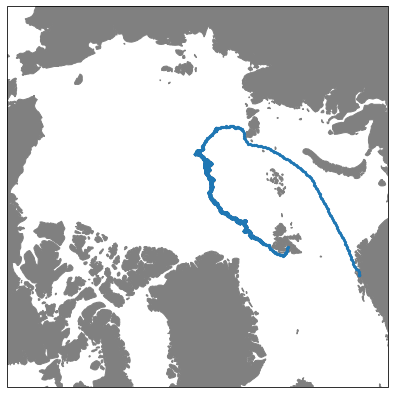

In [9]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(projection=map_proj)
ax.set_extent(map_extent, crs=map_proj)
ax.add_feature(cfeature.LAND, facecolor='0.5')
gdf.plot(ax=ax, markersize=5)

From [Stefan Hendricks blog post](https://blogs.helmholtz.de/polarstern/en/2019/10/mapping-floes/), the Polarstern moored at the first floe on about 15 October 2019 and then cast off from the floe on 16 May 2020 to exchange personnel in Isfjord, Svalbard ([CIRES MOSAIC Blog](https://mosaic.colorado.edu/blog-rv-polarstern))

In [10]:
on_floe_gdf = gdf['2019-10-15':'2020-05-16']
on_floe_gdf

datetime
2019-10-15 00:00:00       POINT (6076.023 568417.754)
2019-10-15 01:00:00       POINT (6220.553 568334.992)
2019-10-15 02:00:00       POINT (6333.911 568212.702)
2019-10-15 03:00:00       POINT (6397.147 568074.130)
2019-10-15 04:00:00       POINT (6397.157 567943.865)
                                    ...              
2020-05-16 19:00:00    POINT (580898.247 -420389.691)
2020-05-16 20:00:00    POINT (580942.943 -420417.648)
2020-05-16 21:00:00    POINT (580885.171 -420546.579)
2020-05-16 22:00:00    POINT (580707.509 -420708.331)
2020-05-16 23:00:00    POINT (580620.486 -420890.273)
Length: 5160, dtype: geometry

<GeoAxesSubplot:>

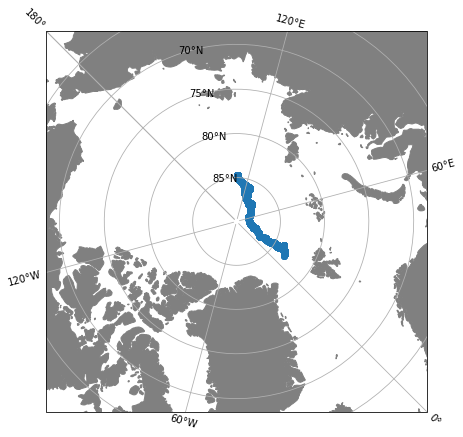

In [11]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(projection=map_proj)
ax.set_extent(map_extent, crs=map_proj)

ax.add_feature(cfeature.LAND, facecolor='0.5')
ax.gridlines(draw_labels=True)

on_floe_gdf.plot(ax=ax)

My strategy is to search for ICESat-2 tracks that fall within a buffer region of the Polarstern drift track.  Rather than searching for every hour, I want to search daily.  To do this I subsample midday locations and define a search radius based on that. However, I need to know how big to set the search radius.

In [12]:
on_floe_midday_gdf = on_floe_gdf[on_floe_gdf.index.hour == 12]
on_floe_midday_gdf

datetime
2019-10-15 12:00:00       POINT (7079.510 567799.097)
2019-10-16 12:00:00      POINT (14985.076 567852.544)
2019-10-17 12:00:00      POINT (20575.430 568545.882)
2019-10-18 12:00:00      POINT (18298.749 561424.802)
2019-10-19 12:00:00      POINT (18354.817 548401.003)
                                    ...              
2020-05-12 12:00:00    POINT (602662.550 -381350.359)
2020-05-13 12:00:00    POINT (592873.133 -406841.127)
2020-05-14 12:00:00    POINT (586160.437 -412203.513)
2020-05-15 12:00:00    POINT (582209.179 -418248.236)
2020-05-16 12:00:00    POINT (580604.954 -420111.880)
Length: 215, dtype: geometry

I calculate the daily average drift speed as the distance between consecutive midday ship positions.  90% of daily drift speeds are less than ~18 km/day.  The maximum drift speed is 27 km/day.

In [13]:
drift_km = np.array([on_floe_midday_gdf[i].distance(on_floe_midday_gdf[i-1]) for i in range(1,len(on_floe_midday_gdf))])
percentiles = [0., 10, 25, 50, 75, 90, 100]
drift_km_pctl = np.percentile(drift_km, q=percentiles)
print("Distribution of daily drift speeds (km/day)")
print("-"*25)
print("Percentile  Drift Speed")
print("-"*25)
for p, q in zip(percentiles, drift_km_pctl):
    print(f" {p:3.0f}         {np.round(q*1e-3):2.0f}")

Distribution of daily drift speeds (km/day)
-------------------------
Percentile  Drift Speed
-------------------------
   0          0
  10          3
  25          5
  50          9
  75         13
  90         18
 100         27


Both the distribution of daily drift and the plot suggest that setting a buffer of 20 km should ensure that the whole drift track is captured.  Buffers are calculated in projected coordinates and then converted to latitude and longitude on WGS84.

<AxesSubplot:>

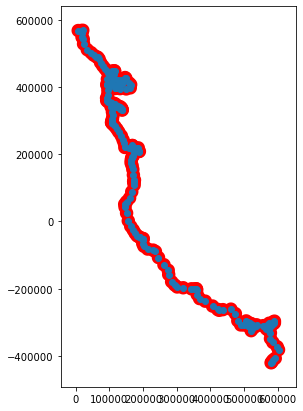

In [14]:
buffer_radius = 20000.
fig, ax = plt.subplots(figsize=(7,7))
on_floe_gdf[on_floe_gdf.index.hour == 12].plot(ax=ax, zorder=3)
on_floe_gdf[on_floe_gdf.index.hour == 12].buffer(buffer_radius).plot(ax=ax, color='r')

I create polygons for search buffers using the `buffer` method in `geopandas`.  This needs to be done in projected coordinates.  However, `CMR` requires coordinates at latitude, longitude pairs - assuming WGS84

In [15]:
polygon_resolution = 3
search_buffers = on_floe_midday_gdf.buffer(buffer_radius, polygon_resolution).to_crs(4326)
search_buffers

datetime
2019-10-15 12:00:00    POLYGON ((132.26952 84.75616, 132.49529 84.849...
2019-10-16 12:00:00    POLYGON ((131.47450 84.75169, 131.68567 84.845...
2019-10-17 12:00:00    POLYGON ((130.91789 84.74190, 131.11857 84.835...
2019-10-18 12:00:00    POLYGON ((131.09750 84.80880, 131.30412 84.902...
2019-10-19 12:00:00    POLYGON ((130.99928 84.92848, 131.20903 85.022...
                                             ...                        
2020-05-12 12:00:00    POLYGON ((13.51457 83.26725, 12.73875 83.23961...
2020-05-13 12:00:00    POLYGON ((11.42276 83.21706, 10.66187 83.18612...
2020-05-14 12:00:00    POLYGON ((10.78337 83.24081, 10.02284 83.20886...
2020-05-15 12:00:00    POLYGON ((10.21913 83.23927, 9.46152 83.20645,...
2020-05-16 12:00:00    POLYGON ((10.02793 83.24158, 9.27101 83.20845,...
Length: 215, dtype: geometry

## Search for IS2 tracks along Polarstern track

Two example workflows, using two different tools, are presented below: the first uses `icepyx`; the second uses the NASA CMR API.  Both examples search for granules for version 004 ICESat-2 seaice freeboard (ATL10) for the first date on the floe.

In [16]:
product = 'ATL10'
version = '004'
search_date = '2019-10-15T12:00:00'

I want to find granules within a day

In [17]:
# Convert search_date to datetime object to allow easy programmatic calculation of start and end dates 
search_datetime = dt.datetime.fromisoformat(search_date)
start_date, end_date = search_datetime - dt.timedelta(hours=12), search_datetime + dt.timedelta(hours=12)
print(start_date, end_date)

2019-10-15 00:00:00 2019-10-16 00:00:00


## Query using `icepyx`

In [18]:
spatial_extent = list(search_buffers[search_date].exterior.coords)

#one_day = ipx.Query(product, spatial_extent, [start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")])
#one_day.avail_granules(ids=True)

In [19]:
import netrc
url = "urs.earthdata.nasa.gov"
email = "apbarret@nsidc.org"
uid, _, _ = netrc.netrc().authenticators(url)
#one_day.earthdata_login(uid, email)

In [20]:
#one_day.order_granules(verbose=True)

In [21]:
#one_day.download_granules(".")

In [22]:
#ls -ltr | tail

results = []
for result in one_day.granules.avail:
    for link in result['links']:
        if link['href'].endswith('.h5') | link['href'].endswith('.xml'):
            results.append(link['href'])
        
for result in results:
    print(result)

### Query using `CMR`

In [57]:
from shapely.geometry.polygon import orient

def polygon_area(poly):
    x, y = map(list, zip(*poly))
    if (x[0] != x[-1]) & (y[0] != y[-1]):
        x.append(x[0])
        y.append(y[0])
    return sum([((x[i+1] - x[i]) * (y[i+1] + y[i]) * 0.5) for i in range(len(x)-1)])
    
    
def isccw(poly):
    """Return the signed area enclosed by a ring using the linear time
algorithm at http://www.cgafaq.info/wiki/Polygon_Area. A value >= 0
indicates a counter-clockwise oriented ring."""
    if polygon_area(poly) >= 0:
        return True
    else:
        return False 


def shapely_to_cmr(poly):
    """Converts shapely polygon to string containing lon, lat
       expected by CMR.  CMR expects coordinates to be counter-
       clockwise.  Code automatically reverses this"""
    poly_ccw = orient(poly, sign=1.0)  # Force polygons to be counter-clockwise
    assert LinearRing(poly_ccw.exterior.coords).is_ccw, "Polygon is not counter-clockwise"
    return ",".join([f"{x},{y}" for x, y in poly_ccw.exterior.coords])


def _circle_params(point, search_radius = 1000.):
    '''Helper function to returns list of parameters for search circle'''
    #latitude, longitude = df.values
    return f'{point.x},{point.y},{int(search_radius)}'


def _bounding_box(point, search_box=0.5):
    '''Helper function to return bounding box'''
    longitude, latitude = point.x, point.y
    #latitude, longitude = df.values
    ll_lon = longitude - search_box/2.
    ll_lat = latitude - search_box/2.
    ur_lon = longitude + search_box/2.
    ur_lat = latitude + search_box/2.
    return '{0},{1},{2},{3}'.format(str(ll_lon), str(ll_lat), str(ur_lon), str(ur_lat))



The cell below submits a query for a single date

In [59]:
# Will be added to icepyx very soon
results = cmr.cmr_search(
    product, 
    version, 
    start_date.isoformat(),  # CMR API expects iso format date strings
    end_date.isoformat(), 
    #circle=_circle_params(on_floe_midday_gdf.to_crs(4326)[search_date], search_radius=20000.),  # !!does not work!!
    #bounding_box = _bounding_box(on_floe_midday_gdf.to_crs(4326)[search_date])  # Works
    polygon=shapely_to_cmr(search_buffers.to_crs(4326)[search_date]),
)
results

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=ATL10&version=004&version=04&version=4&temporal[]=2019-10-15T00:00:00,2019-10-16T00:00:00&polygon[]=132.2695150670986,84.75615504568658,132.58187940257017,84.66523410956339,133.3280238302952,84.60024801149218,134.30995739594945,84.57746924282515,135.28597635839736,84.60247655332547,136.01541271188077,84.66914197187609,136.30356287248907,84.76074645590629,136.0518125034308,84.85336364662894,135.3039722104731,84.92160560021999,134.2595762690931,84.94594375707206,133.22287366942112,84.91923630677863,132.4952857089011,84.8493152503536,132.2695150670986,84.75615504568658

Found 1 matches.


['https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2019.10.15/ATL10-01_20191015021730_02780501_004_01.h5',
 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2019.10.15/ATL10-01_20191015021730_02780501_004_01.iso.xml']

Here, we automate search queries to search for all granules along Polarstern drift track 

In [73]:
big_list_of_granules = []
for search_date, polygon in search_buffers.iteritems():
    start_date, end_date = search_date - dt.timedelta(hours=12), search_date + dt.timedelta(hours=12)
    results = cmr.cmr_search(
        product, 
        version, 
        start_date.isoformat(),  # CMR API expects iso format date strings
        end_date.isoformat(), 
        polygon=shapely_to_cmr(search_buffers.to_crs(4326)[search_date]),
        )
    big_list_of_granules = big_list_of_granules + results
        
for g in big_list_of_granules:
    print(g)

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=ATL10&version=004&version=04&version=4&temporal[]=2019-10-15T00:00:00,2019-10-16T00:00:00&polygon[]=132.2695150670986,84.75615504568658,132.58187940257017,84.66523410956339,133.3280238302952,84.60024801149218,134.30995739594945,84.57746924282515,135.28597635839736,84.60247655332547,136.01541271188077,84.66914197187609,136.30356287248907,84.76074645590629,136.0518125034308,84.85336364662894,135.3039722104731,84.92160560021999,134.2595762690931,84.94594375707206,133.22287366942112,84.91923630677863,132.4952857089011,84.8493152503536,132.2695150670986,84.75615504568658

Found 1 matches.
Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=ATL10&version=004&version=04&version=4&tempor

Download the granule

In [76]:
with open('mosaic_polarstern_drift_track_granules.txt', 'w') as f:
    for g in big_list_of_granules:
        f.write(g+'\n')

In [78]:
ls /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10

2019/  2020/


In [82]:
cmr.cmr_download(big_list_of_granules[264:], outpath='/media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10')

001/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200130064941_05280601_004_01.h5
002/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200130064941_05280601_004_01.iso.xml
003/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200131014110_05400601_004_01.h5
004/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200131014110_05400601_004_01.iso.xml
005/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200131062402_05430601_004_01.h5
006/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200131062402_05430601_004_01.iso.xml
007/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200201011531_05550601_004_01.h5
008/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200201011531_05550601_004_01.iso.xml
009/278: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200201055822_05580601_004_01.h5
010/278: /media/apbarret/a

In [101]:
from pathlib import Path
import os
data_path = Path("/media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10")
downloaded_files = [f.name for f in data_path.glob("ATL10-01_*")]

In [102]:
downloaded_files[0]

'ATL10-01_20191229075620_00400601_004_01.h5'

In [100]:
os.path.basename(big_list_of_granules[0])

'ATL10-01_20191015021730_02780501_004_01.h5'

In [104]:
not_downloaded = []
for f in big_list_of_granules:
    if os.path.basename(f) not in downloaded_files:
        not_downloaded.append(f)
print(not_downloaded)

['https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.09/ATL10-01_20200309090036_11250601_004_01.iso.xml', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.10/ATL10-01_20200310052623_11380601_004_01.h5', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.10/ATL10-01_20200310052623_11380601_004_01.iso.xml', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.10/ATL10-01_20200310070040_11390601_004_01.h5', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.10/ATL10-01_20200310070040_11390601_004_01.iso.xml', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.10/ATL10-01_20200310083458_11400601_004_01.h5', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.10/ATL10-01_20200310083458_11400601_004_01.iso.xml', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.11/ATL10-01_20200311050044_11530601_004_01.h5', 'https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL10.004/2020.03.11/ATL10-01_20200311050044_11530601_004_01.iso.xml', 'h

In [106]:
cmr.cmr_download(not_downloaded, outpath='/media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10')

01/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200309090036_11250601_004_01.iso.xml
02/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200310052623_11380601_004_01.h5
03/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200310052623_11380601_004_01.iso.xml
04/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200310070040_11390601_004_01.h5
05/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200310070040_11390601_004_01.iso.xml
06/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200310083458_11400601_004_01.h5
07/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200310083458_11400601_004_01.iso.xml
08/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200311050044_11530601_004_01.h5
09/66: /media/apbarret/andypbarrett_work/Data/ICESat-2/ATL10/ATL10-01_20200311050044_11530601_004_01.iso.xml
10/66: /media/apbarret/andypbarrett_wor

cmr.cmr_download(results[:1])

## Lets see what this looks like

In [ ]:
def read_atl10(filepath):
    '''Read ATL10 (Freeboard)'''
    f = h5py.File(filepath, 'r')
    gt2l = xr.Dataset({
        'freeboard': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]), 
        'geoseg_beg': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['geoseg_beg'][:]), 
        'geoseg_end': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['geoseg_end'][:]), 
        'latitude': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['latitude'][:]), 
        'longitude': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['longitude'][:])
    },)
    # Add segment center as alongtrack distance coordinate
    x = (gt2l.geoseg_beg + gt2l.geoseg_end.values) * 0.5
    gt2l.coords['x'] = x.values
    return gt2l

In [ ]:
ls ATL10*.h5

In [ ]:
filepath = 'ATL10-01_20191015021730_02780501_003_03.h5'
gtl2 = read_atl10(filepath)
gtl2

In [ ]:
filepath = "ATL10-02_20191014230855_02760501_003_03.h5"
gtl3 = read_atl10(filepath)
gtl3

In [ ]:
buffer_coords = list(search_buffers[search_date].exterior.coords)
buffer_coords[-1] == buffer_coords[0]

In [ ]:
point = on_floe_midday_gdf[search_date]

print(point.x, point.y)

mapcenter_x, mapcenter_y = point.x, point.y
dx, dy = 100000., 100000.

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=map_proj)
ax.set_extent([mapcenter_x-dx, mapcenter_x+dx, mapcenter_y-dy, mapcenter_y+dy], map_proj)
ax.add_feature(cfeature.LAND, facecolor='0.5')
ax.gridlines(draw_labels=True)

on_floe_midday_gdf.plot(ax=ax)
ax.plot(point.x, point.y, marker='P', color='r', markersize=10)  # Add geometries does not appear to work for single point
ax.add_geometries([search_buffers[search_date]], crs=ccrs.PlateCarree(), facecolor='g', zorder=0)
ax.plot(gtl2.longitude, gtl2.latitude, transform=ccrs.PlateCarree(), color='k')
ax.plot(gtl3.longitude, gtl3.latitude, transform=ccrs.PlateCarree(), color='k', linestyle='--')

In [ ]:
map_proj = ccrs.NorthPolarStereo()

polarstern_lat, polarstern_lon = on_floe_track_df.loc[start_date.strftime('%Y-%m-%d'), :].values

# Transform lat, lon to NorthPolarstereo x, y
mapcenter_x, mapcenter_y = map_proj.transform_point(polarstern_lon, polarstern_lat, ccrs.PlateCarree())

#polarstern_track = map_proj.transform_points(ccrs.PlateCarree(), on_floe_track_df["Longitude"].values, on_floe_track_df["Latitude"].values)
polarstern_track_x, polarstern_track_y = polarstern_track[:,0], polarstern_track[:,1]

is2_path = map_proj.transform_points(ccrs.PlateCarree(), gtl2.longitude.values, gtl2.latitude.values)
is2_path_x, is2_path_y = is2_path[:,0], is2_path[:,1]

In [ ]:
dx, dy = 50000., 50000.

# compute circle centered on Polarstern for plotting
r = 10000
theta = np.linspace(0.,360.,360) * np.pi / 180.
x1 = mapcenter_x + r*np.cos(theta)
y1 = mapcenter_y + r*np.sin(theta)
#rx, ry = 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=map_proj)
ax.set_extent([mapcenter_x-dx, mapcenter_x+dx, mapcenter_y-dy, mapcenter_y+dy], map_proj)
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)

ax.scatter([mapcenter_x], [mapcenter_y], 100, transform=map_proj, label='Polarstern {0}'.format(search_date))
ax.plot(polarstern_track_x, polarstern_track_y, lw=5, transform=map_proj, label='Polarstern drift track')
ax.plot(is2_path_x, is2_path_y, lw=5, transform=map_proj, label='ICESat-2 gtl2 ground track')
ax.plot(x1, y1, lw=3, ls='--', transform=map_proj, label='20 km perimeter')
ax.legend(fontsize=20)